## 知识点补充

### tf.nn.dropout

`tf.nn.dropout(x, rate, noise_shape=None, seed=None, name=None)`

参数：

- rate: The probability that each element is dropped. For example, setting rate=0.1 would drop 10% of input elements.

- noise_shape: A 1-D Tensor of type int32, representing the shape for randomly generated keep/drop flags

### tf.slice(), tf.split(), tf.concat()和 tf.stack() 详解

目标是将一个5x4x3的tensor张量转换为4x15的张量和20x3的张量，具体转换效果如下图所示。

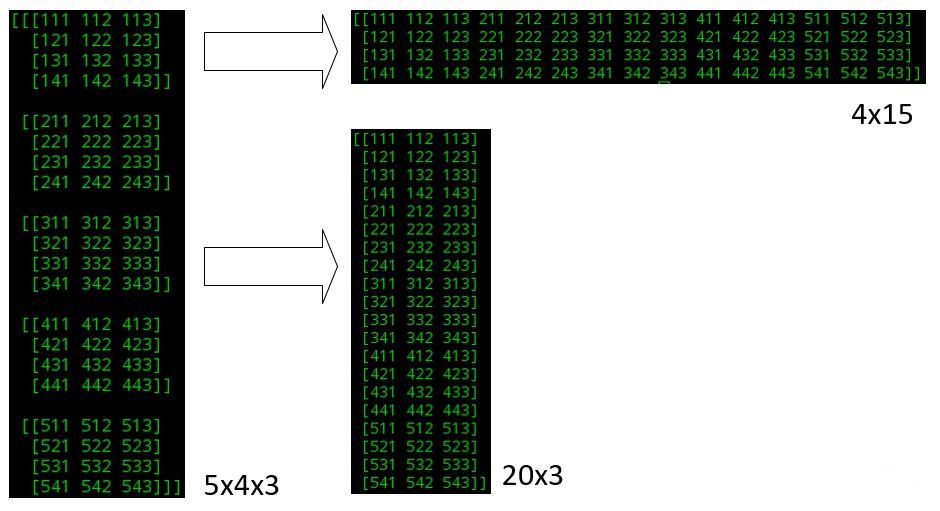

`tf.slice(input, begin, size)`

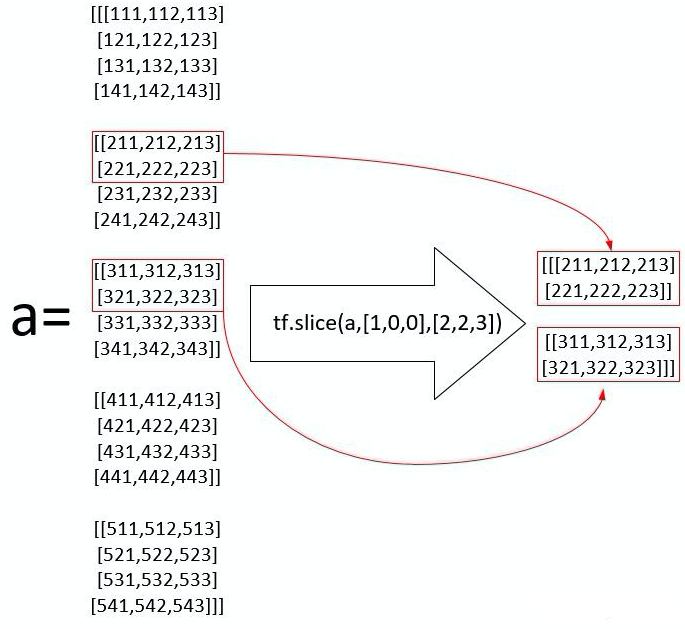

`tf.split(input, num_or_size_split, axis=0, num=None)`

参数：

- num_or_size_split:可以是一个数字，就是按照axis等分为几个矩阵，也可以是个列表，列表的和应该等于该维度的大小。

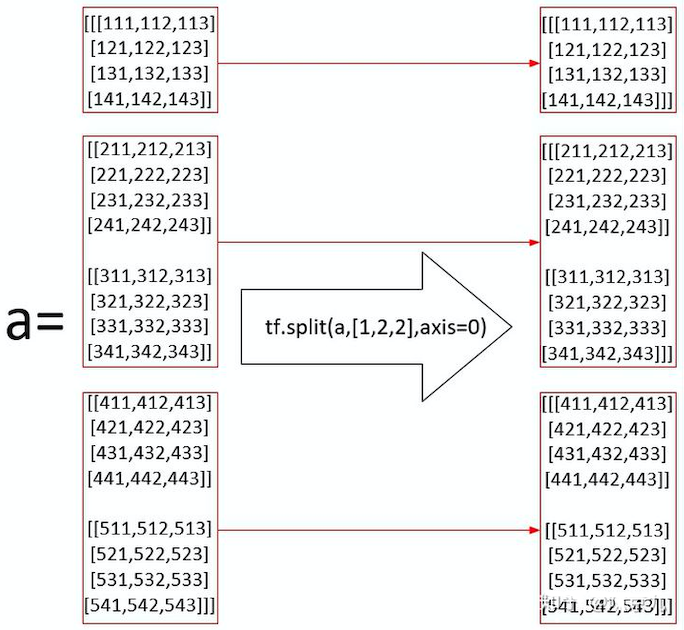

`tf.concat(input, axis)`

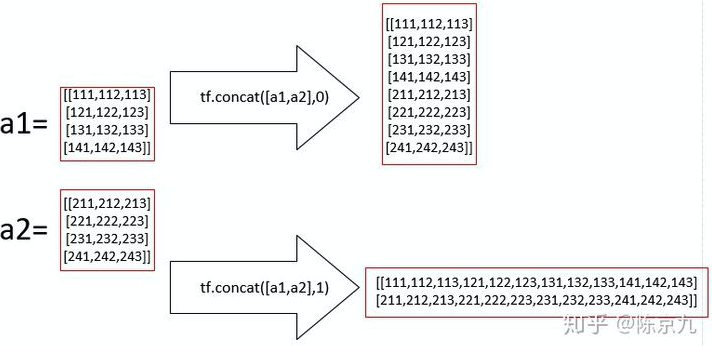

`tf.stack(input, axis=0)`

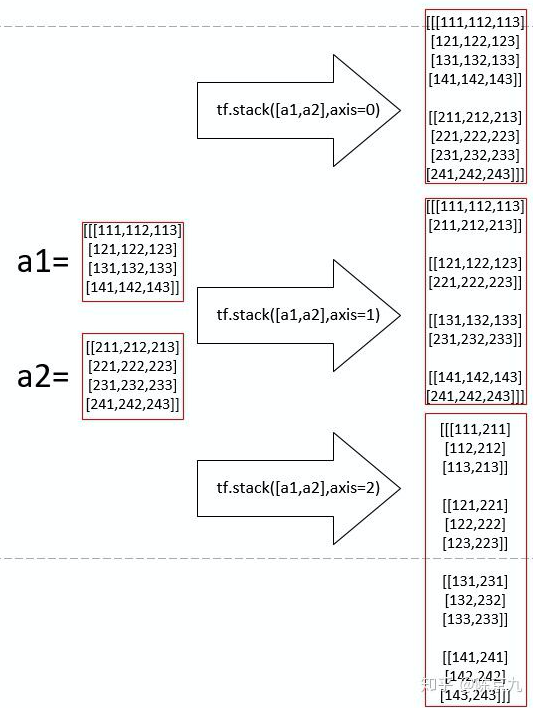

Tacotron2中conv_layer给予了neural net类似于n-gram感知上下文的能力，主要是由于RNN很难捕获长时依赖，并且conv-layer使得模型对不发音字符更具有鲁棒性。

In [ ]:
class EncoderConvolutions:
    """Encoder convolutional layers used to find local dependencies in inputs characters.
    """
    def __init__(self, is_training, hparams, activation=tf.nn.relu, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is training or in inference to control dropout
            kernel_size: tuple or integer, The size of convolution kernels
            channels: integer, number of convolutional kernels
            activation: callable, postnet activation function for each convolutional layer
            scope: Postnet scope.
        """
        super(EncoderConvolutions, self).__init__()
        self.is_training = is_training

        self.kernel_size = hparams.enc_conv_kernel_size
        self.channels = hparams.enc_conv_channels
        self.activation = activation
        self.scope = 'enc_conv_layers' if scope is None else scope
        self.drop_rate = hparams.tacotron_dropout_rate
        self.enc_conv_num_layers = hparams.enc_conv_num_layers
        self.bnorm = hparams.batch_norm_position
        
    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            x = inputs
            for i in range(self.enc_conv_num_layers):
                x = conv1d(x, self.kernel_size, self.channels, self.activation,
                    self.is_training, self.drop_rate, self.bnorm, 'conv_layer_{}_'.format(i + 1)+self.scope)
        return x        

In [ ]:
class EncoderRNN:
    """Encoder bidirectional one layer LSTM
    """
    def __init__(self, is_training, size=256, zoneout=0.1, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is training or in inference to control zoneout
            size: integer, the number of LSTM units for each direction
            zoneout: the zoneout factor
            scope: EncoderRNN scope.
        """
        super(EncoderRNN, self).__init__()
        self.is_training = is_training

        self.size = size
        self.zoneout = zoneout
        self.scope = 'encoder_LSTM' if scope is None else scope

        #Create forward LSTM Cell
        self._fw_cell = ZoneoutLSTMCell(size, is_training,
            zoneout_factor_cell=zoneout,
            zoneout_factor_output=zoneout,
            name='encoder_fw_LSTM') #前向RNN

        #Create backward LSTM Cell
        self._bw_cell = ZoneoutLSTMCell(size, is_training,
            zoneout_factor_cell=zoneout,
            zoneout_factor_output=zoneout,
            name='encoder_bw_LSTM') #后向RNN

    def __call__(self, inputs, input_lengths):
        with tf.variable_scope(self.scope):
            outputs, (fw_state, bw_state) = tf.nn.bidirectional_dynamic_rnn(
                self._fw_cell,
                self._bw_cell,
                inputs,
                sequence_length=input_lengths,
                dtype=tf.float32,
                swap_memory=True) #sequence_length:输入序列的实际长度（可选，默认为最大长度）
            #用bidirectional-RNN是为了确保模型能够同时感知前向和后向的信息
            return tf.concat(outputs, axis=2) # Concat and return forward + backward outputs

### ZoneoutLSTM

https://arxiv.org/abs/1606.01305
它不是单独的cell,而是指训练时的一个trick.

A novel method for regularizing RNNs. At each timestep, zoneout stochastically forces some hidden units to maintain their previous values. Like dropout, zoneout uses random noise to train a pseudo-ensemble(伪集成), improving generalization. 它使用随机"identity-masking"而不是"zero-masking"来注入噪声。我们推测identity-masking更适合RNN,因为它使网络更容易保留前一个时刻的信息，并且有助于而不是阻碍梯度信息向后流动 But by preserving instead of dropping hidden units, gradient information and state information are more readily propagated(更容易传播) through time, as in feedforward stochastic depth networks. 

其中**ZoneoutLSTM**: A method for regularizing RNN. At each steps, zoneout stochastically forces some hidden units to maintain their previous values. Zoneout uses random noises to train a pseudo-ensemble, improving generalization. By preserving instead of dropping hidden units, gradient information and state information are more readily propagated through time, as in feedforward stochastic depth networks.

LSTM is defined as follow:
$$i_t,f_t,o_t=\sigma(W_xx_t+W_th_{h-1}+b)$$

$$g_t=tanh(W_{xg} x_t+W_{hg}h_{t-1}+b_g)$$

$$c_t=f_t \odot c_{t-1}+i_t \odot g_t$$

$$h_t=o_t \odot tanh(c_t)$$

In [ ]:
class ZoneoutLSTMCell(tf.nn.rnn_cell.RNNCell):
    '''Wrapper for tf LSTM to create Zoneout LSTM Cell
    inspired by:
    https://github.com/teganmaharaj/zoneout/blob/master/zoneout_tensorflow.py
    Published by one of 'https://arxiv.org/pdf/1606.01305.pdf' paper writers.
    Many thanks to @Ondal90 for pointing this out. You sir are a hero!
    '''
    def __init__(self, num_units, is_training, zoneout_factor_cell=0., zoneout_factor_output=0., state_is_tuple=True, name=None):
        '''Initializer with possibility to set different zoneout values for cell/hidden states.
        '''
        zm = min(zoneout_factor_output, zoneout_factor_cell)
        zs = max(zoneout_factor_output, zoneout_factor_cell)

        if zm < 0. or zs > 1.:
            raise ValueError('One/both provided Zoneout factors are not in [0, 1]')

        self._cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple, name=name)
        self._zoneout_cell = zoneout_factor_cell
        self._zoneout_outputs = zoneout_factor_output
        self.is_training = is_training
        self.state_is_tuple = state_is_tuple

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        '''Runs vanilla LSTM Cell and applies zoneout.
        '''
        #Apply vanilla LSTM
        output, new_state = self._cell(inputs, state, scope)

        if self.state_is_tuple:
            (prev_c, prev_h) = state
            (new_c, new_h) = new_state
        else:
            num_proj = self._cell._num_units if self._cell._num_proj is None else self._cell._num_proj
            prev_c = tf.slice(state, [0, 0], [-1, self._cell._num_units])
            prev_h = tf.slice(state, [0, self._cell._num_units], [-1, num_proj])
            new_c = tf.slice(new_state, [0, 0], [-1, self._cell._num_units])
            new_h = tf.slice(new_state, [0, self._cell._num_units], [-1, num_proj])

        #Apply zoneout
        if self.is_training:
            #nn.dropout takes keep_prob (probability to keep activations) not drop_prob (probability to mask activations)!
            c = (1 - self._zoneout_cell) * tf.nn.dropout(new_c - prev_c, (1 - self._zoneout_cell)) + prev_c
            h = (1 - self._zoneout_outputs) * tf.nn.dropout(new_h - prev_h, (1 - self._zoneout_outputs)) + prev_h

        else:
            c = (1 - self._zoneout_cell) * new_c + self._zoneout_cell * prev_c
            h = (1 - self._zoneout_outputs) * new_h + self._zoneout_outputs * prev_h

        new_state = tf.nn.rnn_cell.LSTMStateTuple(c, h) if self.state_is_tuple else tf.concat(1, [c, h])

        return output, new_state

zoneoutLSTM is defined as follow:

$$c_t=d_t^c\odot c_{t-1}+(1-d^c_t)\odot (f_t \odot c_{t-1}+i_t \odot g_t)$$

$$h_t=d_t^h\odot h_{t-1}+(1-d^h_t)\odot (o_t \odot tanh(c_t))$$

Now we get encoder features（context vector）

In [ ]:
class Prenet:
    """Two fully connected layers used as an information bottleneck for the attention.
    """
    def __init__(self, is_training, layers_sizes=[256, 256], drop_rate=0.5, activation=tf.nn.relu, scope=None):
        """
        Args:
            layers_sizes: list of integers, the length of the list represents the number of pre-net
                layers and the list values represent the layers number of units
            activation: callable, activation functions of the prenet layers.
            scope: Prenet scope.
        """
        super(Prenet, self).__init__()
        self.drop_rate = drop_rate

        self.layers_sizes = layers_sizes
        self.activation = activation
        self.is_training = is_training

        self.scope = 'prenet' if scope is None else scope

    def __call__(self, inputs):
        x = inputs

        with tf.variable_scope(self.scope):
            for i, size in enumerate(self.layers_sizes):
                dense = tf.layers.dense(x, units=size, activation=self.activation,
                    name='dense_{}'.format(i + 1))
                #The paper discussed introducing diversity in generation at inference time
                #by using a dropout of 0.5 only in prenet layers (in both training and inference).
                x = tf.layers.dropout(dense, rate=self.drop_rate, training=True,
                    name='dropout_{}'.format(i + 1) + self.scope)
        return x

In [ ]:
class Postnet:
    """Postnet that takes final decoder output and fine tunes it (using vision on past and future frames)
    """
    def __init__(self, is_training, hparams, activation=tf.nn.tanh, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is training or in inference to control dropout
            kernel_size: tuple or integer, The size of convolution kernels
            channels: integer, number of convolutional kernels
            activation: callable, postnet activation function for each convolutional layer
            scope: Postnet scope.
        """
        super(Postnet, self).__init__()
        self.is_training = is_training

        self.kernel_size = hparams.postnet_kernel_size
        self.channels = hparams.postnet_channels
        self.activation = activation
        self.scope = 'postnet_convolutions' if scope is None else scope
        self.postnet_num_layers = hparams.postnet_num_layers
        self.drop_rate = hparams.tacotron_dropout_rate
        self.bnorm = hparams.batch_norm_position

    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            x = inputs
            for i in range(self.postnet_num_layers - 1):
                x = conv1d(x, self.kernel_size, self.channels, self.activation,
                    self.is_training, self.drop_rate, self.bnorm, 'conv_layer_{}_'.format(i + 1)+self.scope)
            x = conv1d(x, self.kernel_size, self.channels, lambda _: _, self.is_training, self.drop_rate, self.bnorm,
                'conv_layer_{}_'.format(5)+self.scope)
        return x


In [ ]:
def conv1d(inputs, kernel_size, channels, activation, is_training, drop_rate, bnorm, scope):
    assert bnorm in ('before', 'after')
    with tf.variable_scope(scope):
        conv1d_output = tf.layers.conv1d(inputs,filters=channels,kernel_size=kernel_size,
            activation=activation if bnorm == 'after' else None,padding='same')
        batched = tf.layers.batch_normalization(conv1d_output, training=is_training)
        activated = activation(batched) if bnorm == 'before' else batched
        return tf.layers.dropout(activated, rate=drop_rate, training=is_training,name='dropout_{}'.format(scope))

In [ ]:
class FrameProjection:
    """Projection layer to r * num_mels dimensions or num_mels dimensions
    """
    def __init__(self, shape=80, activation=None, scope=None):
        """
        Args:
            shape: integer, dimensionality of output space (r*n_mels for decoder or n_mels for postnet)
            activation: callable, activation function
            scope: FrameProjection scope.
        """
        super(FrameProjection, self).__init__()

        self.shape = shape
        self.activation = activation

        self.scope = 'Linear_projection' if scope is None else scope
        self.dense = tf.layers.Dense(units=shape, activation=activation, name='projection_{}'.format(self.scope))

    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            #If activation==None, this returns a simple Linear projection
            #else the projection will be passed through an activation function
            # output = tf.layers.dense(inputs, units=self.shape, activation=self.activation,
            # 	name='projection_{}'.format(self.scope))
            output = self.dense(inputs)

            return output

In [ ]:
class StopProjection:
    """Projection to a scalar and through a sigmoid activation
    """
    def __init__(self, is_training, shape=1, activation=tf.nn.sigmoid, scope=None):
        """
        Args:
            is_training: Boolean, to control the use of sigmoid function as it is useless to use it
                during training since it is integrate inside the sigmoid_crossentropy loss
            shape: integer, dimensionality of output space. Defaults to 1 (scalar)
            activation: callable, activation function. only used during inference
            scope: StopProjection scope.
        """
        super(StopProjection, self).__init__()
        self.is_training = is_training

        self.shape = shape
        self.activation = activation
        self.scope = 'stop_token_projection' if scope is None else scope

    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            output = tf.layers.dense(inputs, units=self.shape,
                activation=None, name='projection_{}'.format(self.scope))

            #During training, don't use activation as it is integrated inside the sigmoid_cross_entropy loss function
            if self.is_training:
                return output
            return self.activation(output)

In [ ]:
class CBHG:
    def __init__(self, K, conv_channels, pool_size, projections, projection_kernel_size, n_highwaynet_layers, highway_units, rnn_units, bnorm, is_training, name=None):
        self.K = K
        self.conv_channels = conv_channels
        self.pool_size = pool_size

        self.projections = projections
        self.projection_kernel_size = projection_kernel_size
        self.bnorm = bnorm

        self.is_training = is_training
        self.scope = 'CBHG' if name is None else name

        self.highway_units = highway_units
        self.highwaynet_layers = [HighwayNet(highway_units, name='{}_highwaynet_{}'.format(self.scope, i+1)) for i in range(n_highwaynet_layers)]
        self._fw_cell = tf.nn.rnn_cell.GRUCell(rnn_units, name='{}_forward_RNN'.format(self.scope))
        self._bw_cell = tf.nn.rnn_cell.GRUCell(rnn_units, name='{}_backward_RNN'.format(self.scope))

    def __call__(self, inputs, input_lengths):
        with tf.variable_scope(self.scope):
            with tf.variable_scope('conv_bank'):
                #Convolution bank: concatenate on the last axis to stack channels from all convolutions
                #The convolution bank uses multiple different kernel sizes to have many insights of the input sequence
                #This makes one of the strengths of the CBHG block on sequences.
                conv_outputs = tf.concat(
                    [conv1d(inputs, k, self.conv_channels, tf.nn.relu, self.is_training, 0., self.bnorm, 'conv1d_{}'.format(k)) for k in range(1, self.K+1)],
                    axis=-1)

            #Maxpooling (dimension reduction, Using max instead of average helps finding "Edges" in mels)
                maxpool_output = tf.layers.max_pooling1d(conv_outputs,pool_size=self.pool_size,strides=1,padding='same')

            #Two projection layers
            proj1_output = conv1d(maxpool_output, self.projection_kernel_size, self.projections[0], tf.nn.relu, self.is_training, 0., self.bnorm, 'proj1')
            proj2_output = conv1d(proj1_output, self.projection_kernel_size, self.projections[1], lambda _: _, self.is_training, 0., self.bnorm, 'proj2')

            #Residual connection
            highway_input = proj2_output + inputs

            #Additional projection in case of dimension mismatch (for HighwayNet "residual" connection)
            if highway_input.shape[2] != self.highway_units:
                highway_input = tf.layers.dense(highway_input, self.highway_units)

            #4-layer HighwayNet
            for highwaynet in self.highwaynet_layers:
                highway_input = highwaynet(highway_input)
            rnn_input = highway_input

            #Bidirectional RNN
            outputs, states = tf.nn.bidirectional_dynamic_rnn(self._fw_cell,self._bw_cell,rnn_input,sequence_length=input_lengths,dtype=tf.float32)
            return tf.concat(outputs, axis=2) #Concat forward and backward outputs

MaskedMSE中的[sequence_mask]和[_round_up_tf]代码在下面解释

In [ ]:
def MaskedMSE(targets, outputs, targets_lengths, hparams, mask=None):
    '''Computes a masked Mean Squared Error
    '''

    #[batch_size, time_dimension, 1]
    #example:
    #sequence_mask([1, 3, 2], 5) = [[[1., 0., 0., 0., 0.]],
    #                               [[1., 1., 1., 0., 0.]],
    #                               [[1., 1., 0., 0., 0.]]]
    #Note the maxlen argument that ensures mask shape is compatible with r>1
    #This will by default mask the extra paddings caused by r>1
    if mask is None:
        mask = sequence_mask(targets_lengths, hparams.outputs_per_step, True)

    #[batch_size, time_dimension, channel_dimension(mels)]
    ones = tf.ones(shape=[tf.shape(mask)[0], tf.shape(mask)[1], tf.shape(targets)[-1]], dtype=tf.float32)
    mask_ = mask * ones

    with tf.control_dependencies([tf.assert_equal(tf.shape(targets), tf.shape(mask_))]):
        return tf.losses.mean_squared_error(labels=targets, predictions=outputs, weights=mask_)

In [ ]:
def sequence_mask(lengths, r, expand=True):
    '''Returns a 2-D or 3-D tensorflow sequence mask depending on the argument 'expand'
    '''
    max_len = tf.reduce_max(lengths)
    max_len = _round_up_tf(max_len, tf.convert_to_tensor(r))
    if expand:
        return tf.expand_dims(tf.sequence_mask(lengths, maxlen=max_len, dtype=tf.float32), axis=-1)
    return tf.sequence_mask(lengths, maxlen=max_len, dtype=tf.float32)

In [1]:
def _round_up_tf(x, multiple):
    # Tf version of remainder = x % multiple
    remainder = tf.mod(x, multiple)
    # Tf version of return x if remainder == 0 else x + multiple - remainder
    x_round =  tf.cond(tf.equal(remainder, tf.zeros(tf.shape(remainder), dtype=tf.int32)),
        lambda: x,lambda: x + multiple - remainder)
    
    return x_round